In [1]:
import os
import json
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
import helpers as ph
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import dataframe_image as dfi

sns.set_style('darkgrid')

In [2]:
RESULTS_DIR = f'./data/distributions/'
CONTEXT = 'default'
SAVEFIG = True

In [3]:
combined_df = []
for context in ['default', 'steer-qa', 'steer-bio', 'steer-portray']:
    
    cdf = pd.read_csv(os.path.join(RESULTS_DIR, f'Pew_American_Trends_Panel_disagreement_500_{context}_combined.csv'))
    cdf['survey'] = 'Pew_American_Trends_Panel_disagreement_500'
    cdf['context'] = context
    if context != 'default':
        cdf = cdf[cdf['group'] == cdf['steer_group']]
    combined_df.append(cdf)
combined_df = pd.concat(combined_df)
combined_df['Source'] = combined_df.apply(lambda x: 'AI21 Labs' if 'j1-' in x['model_name'].lower() else 'OpenAI',
                                          axis=1)

## Measure steerability

In [4]:
KEYS = ['model_name', 'context', 'attribute', 'group', 'group_order', 'model_order']

grouped = combined_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \
         .sort_values(by=['context', 'model_order', 'group_order'])
grouped['Rep'] = 1 - grouped['WD']

/tmp/ipykernel_5259/2664974887.py:3: FutureWarning: The provided callable <function mean at 0x7f94fc057ce0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = combined_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \


In [5]:
unsteered = grouped[grouped['context'] == 'default'].rename(columns={'WD': 'WD_d',
                                                                     'Rep': 'Rep_d'})
steered = grouped[grouped['context'] != 'default'].sort_values(by='Rep')
steered = steered.groupby([k for k in KEYS if k != 'context'], as_index=False).last()\
                 .rename(columns={'WD': 'WD_s', 'Rep': 'Rep_s'})
result = pd.merge(unsteered, steered, on=[k for k in KEYS if k != 'context']) 

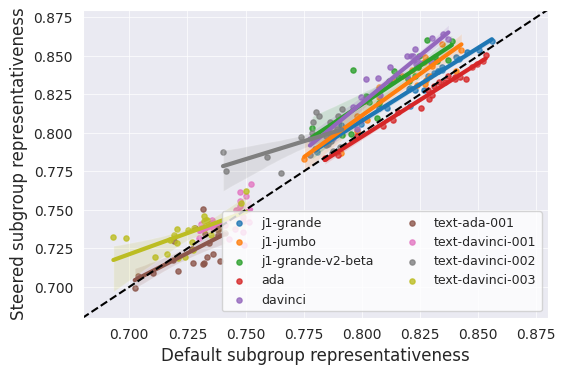

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.set_style('whitegrid')

for model in ph.MODEL_NAMES.values():
    if model not in set(result['model_name'].values): continue 
    c = result[result['model_name'] == model]
    
    reg = sm.OLS(c['Rep_s'], c['Rep_d'])
    slope = reg.fit().params['Rep_d']

    sns.regplot(data=c, x='Rep_d', y='Rep_s', ax=ax, 
                label=model, 
                line_kws={'linewidth': 3},
                scatter_kws={'s': 14})
    
xx = np.linspace(0.66, 0.9, 10)
plt.legend(loc=4, fontsize=9, ncol=2)
ax.plot(xx, xx, 'k--')
ax.set_xlim([0.68, 0.88])
ax.set_ylim([0.68, 0.88])

plt.xlabel('Default subgroup representativeness', fontsize=12)
plt.ylabel('Steered subgroup representativeness', fontsize=12)
plt.grid(linestyle='-', linewidth=0.5)
if SAVEFIG: plt.savefig('steerability.png', bbox_inches="tight")
plt.show()

## Steerability by topic

In [7]:
topic_info = np.load('./data/human_resp/topic_mapping.npy', allow_pickle=True).item()

In [8]:
combined_df['topic'] = combined_df.apply(lambda x: topic_info[x['question']]['cg'], axis=1)
combined_df = combined_df.explode(['topic'])

In [9]:
KEYS = ['Source', 'model_name', 'context', 'attribute', 'group', 'group_order', 'model_order', 'topic']

grouped_topic = combined_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \
         .sort_values(by=['context', 'model_order', 'group_order'])
grouped_topic['Rep'] = 1 - grouped_topic['WD']

/tmp/ipykernel_5259/1678378457.py:3: FutureWarning: The provided callable <function mean at 0x7f94fc057ce0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_topic = combined_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \


In [10]:
steered_topic = grouped_topic[grouped_topic['context'] != 'default'].sort_values(by='Rep')
steered_topic = steered_topic.groupby([k for k in KEYS if k != 'context'], as_index=False).last()\
                 .rename(columns={'WD': 'WD_s', 'Rep': 'Rep_s', 'model_name': ''})

In [11]:
steered_topic

,Source,,attribute,group,group_order,model_order,topic,context,WD_s,Rep_s
0,AI21 Labs,j1-grande,CREGION,Northeast,0,3,community health,steer-portray,0.154932,0.845068
1,AI21 Labs,j1-grande,CREGION,Northeast,0,3,"corporations, banks, technology and automation",steer-portray,0.156863,0.843137
2,AI21 Labs,j1-grande,CREGION,Northeast,0,3,crime/security,steer-portray,0.193719,0.806281
3,AI21 Labs,j1-grande,CREGION,Northeast,0,3,discrimination,steer-bio,0.167536,0.832464
4,AI21 Labs,j1-grande,CREGION,Northeast,0,3,economy and inequality,steer-qa,0.139665,0.860335
...,...,...,...,...,...,...,...,...,...,...
4549,OpenAI,text-davinci-003,SEX,Male,0,11,relationships and family,steer-portray,0.249254,0.750746
4550,OpenAI,text-davinci-003,SEX,Male,0,11,religion,steer-portray,0.219925,0.780075
4551,OpenAI,text-davinci-003,SEX,Male,0,11,science,steer-qa,0.269328,0.730672
4552,OpenAI,text-davinci-003,SEX,Male,0,11,self-perception and values,steer-portray,0.319784,0.680216


In [12]:

import threading
import dataframe_image as dfi
from pathlib import Path

# 确保输出目录存在
Path('./figures').mkdir(exist_ok=True)

# 把导出动作放到独立线程
def _export(img, path):
    """
    在线程中执行 dfi.export，避免 Playwright 与 asyncio 冲突
    """
    dfi.export(img, path)

styles = ph.VIS_STYLES
styles[-1]['props'][-1] = (styles[-1]['props'][-1][0], "105%")

for attribute in np.unique(steered_topic['attribute']):
    print(attribute)
    table = pd.pivot_table(
        steered_topic[steered_topic['attribute'] == attribute],
        columns=['Source', ''],
        index='group',
        values='Rep_s',
        sort=False
    )
    table_vis = (
        table.style
        .background_gradient('Reds', axis=1)
        .set_table_styles(styles)
        .set_properties(**{"font-size": "0.8rem"})
        .format(precision=3)
    )

    if SAVEFIG:
        # 启动新线程完成截图
        threading.Thread(
            target=_export,
            args=(table_vis, f'./figures/steerability_{attribute}.png'),
            daemon=True
        ).start()

    display(table_vis)

CREGION


EDUCATION


INCOME


POLIDEOLOGY


POLPARTY


RACE


RELIG


SEX


Exception in thread Thread-10 (_export):
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/root/miniconda3/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_5259/3890877059.py", line 13, in _export
  File "/root/miniconda3/lib/python3.12/site-packages/dataframe_image/_pandas_accessor.py", line 225, in export
    img_str = converter(html)
              ^^^^^^^^^^^^^^^
  File "/root/miniconda3/lib/python3.12/site-packages/dataframe_image/converter/browser/base.py", line 198, in run
    im = self.screenshot(html)
         ^^^^^^^^^^^^^^^^^^^^^
  File "/root/miniconda3/lib/python3.12/site-packages/dataframe_image/converter/browser/playwright_converter.py", line 57, in screenshot
    raise Error(
pl